In [1]:
#importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#loading the engagement data
df_eng = pd.read_csv('takehome_user_engagement.csv')
#changing 'time_stamp' column to datetime format
df_eng['time_stamp'] = pd.to_datetime(df_eng['time_stamp'])

In [3]:
#getting a glance on dataframe
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [4]:
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
# checking the number of unique users that has engagement data. 
# It is possible that not all of the users have this information
df_eng.user_id.nunique()

8823

In [6]:
# creating a dataframe that contains user_id and time stamp for first activity.

df_first_active = pd.DataFrame(df_eng.groupby('user_id')['time_stamp'].min()).reset_index().rename(columns={'time_stamp':'first_active'})

In [7]:
df_first_active.head()

,user_id,first_active
0,1,2014-04-22 03:53:30
1,2,2013-11-15 03:45:04
2,3,2013-03-19 23:14:52
3,4,2013-05-22 08:09:28
4,5,2013-01-22 10:14:20


In [8]:
#setting 'time_stamp' column as index
df_eng.set_index('time_stamp',inplace=True)

In [9]:
df_eng.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [10]:
#grouping the dataframe by 'user_id' and calculating rolling sum within 7 days on the 'visited' column. This creates
#a pandas series. Converting this series into dataframe.
df_adopted_user = pd.DataFrame(df_eng.groupby('user_id')['visited'].rolling(window='7D').sum())

#grouping the dataframe based on 'user_id' and getting the maximum value of 'visited' column for each user_id 
df_adopted_user = pd.DataFrame(df_adopted_user.groupby('user_id')['visited'].max())

#creating a new column 'adopted_user' and assigning True, False values weather visited >=3 
#or not (criteria for adopted_user)
df_adopted_user['is_adopted'] = df_adopted_user.visited>=3

#replacing False with 0 and True with 1 since I wil use it as target for the classification algorithm.
df_adopted_user.replace({False:0,True:1},inplace=True)
df_adopted_user = df_adopted_user.reset_index()



In [11]:
# merging 'df_first_active' and 'df_adopted_user' data frames.

df_adopted_user = df_adopted_user.merge(df_first_active,on='user_id')
df_adopted_user.head()

,user_id,visited,is_adopted,first_active
0,1,1.0,0,2014-04-22 03:53:30
1,2,3.0,1,2013-11-15 03:45:04
2,3,1.0,0,2013-03-19 23:14:52
3,4,1.0,0,2013-05-22 08:09:28
4,5,1.0,0,2013-01-22 10:14:20


In [12]:
# loading the user data frame
df_user = pd.read_csv('takehome_users.csv',encoding='iso8859_15')

# converting 'creation_time' to datetime format
df_user['creation_time'] = pd.to_datetime(df_user['creation_time'])

#renaming the 'object_id' column name to 'user_id'
df_user.rename(columns={'object_id':'user_id'},inplace=True)

In [13]:
# merging the 'df_user' and 'df_adopted_user' dataframes
df_user = df_user.merge(df_adopted_user,on='user_id')

In [14]:
# Identifying users that are invited by other users.
df_user['is_invited'] = df_user.invited_by_user_id.notnull().astype('int')

# creating a new column 'lag time: time that passed between creation of account and first activity'
df_user['lag_time'] = (df_user['first_active'] - df_user['creation_time'])

# converting lag_time to hours
df_user['lag_time'] = df_user['lag_time']/np.timedelta64(1,'h')

In [15]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   int64         
 1   creation_time               8823 non-null   datetime64[ns]
 2   name                        8823 non-null   object        
 3   email                       8823 non-null   object        
 4   creation_source             8823 non-null   object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    8823 non-null   int64         
 7   enabled_for_marketing_drip  8823 non-null   int64         
 8   org_id                      8823 non-null   int64         
 9   invited_by_user_id          4776 non-null   float64       
 10  visited                     8823 non-null   float64       
 11  is_adopted                  8823 non-null   int64       

In [16]:
# dropping the columns that are not useful for the model.
df_user.drop(['user_id','creation_time','name','email','last_session_creation_time','invited_by_user_id','org_id','visited','first_active'],inplace=True,axis=1)

In [17]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             8823 non-null   object 
 1   opted_in_to_mailing_list    8823 non-null   int64  
 2   enabled_for_marketing_drip  8823 non-null   int64  
 3   is_adopted                  8823 non-null   int64  
 4   is_invited                  8823 non-null   int64  
 5   lag_time                    8823 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 482.5+ KB


In [18]:
df_user.is_adopted.sum()

1602

In [19]:
df_user.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,is_adopted,is_invited,lag_time
0,GUEST_INVITE,1,0,0,1,0.0
1,ORG_INVITE,0,0,1,1,0.0
2,ORG_INVITE,0,0,0,1,0.0
3,GUEST_INVITE,0,0,0,1,24.0
4,GUEST_INVITE,0,0,0,1,120.0


In [20]:
# transforming data frame
df_user_transformed = pd.get_dummies(df_user)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


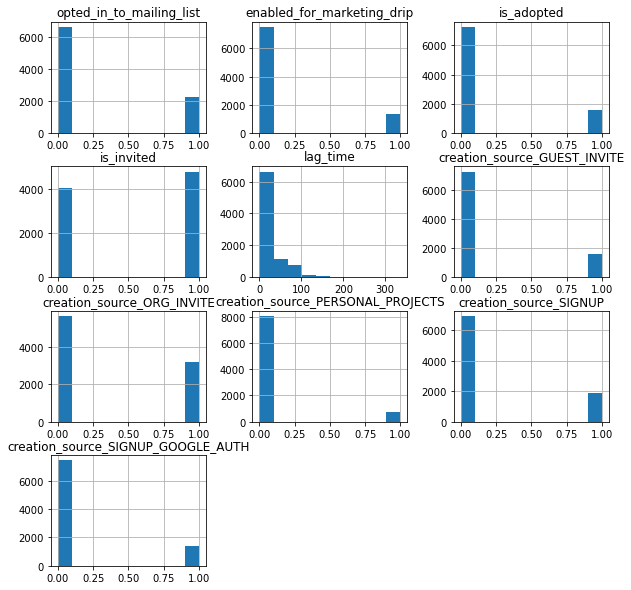

In [22]:
df_user_transformed.hist(figsize=(10,10))
plt.show()

In [23]:
# assigning features and target
X = df_user_transformed.drop(['is_adopted'],axis=1)
y = df_user_transformed.is_adopted

#splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

norm = MinMaxScaler()
norm.fit(X_train)
norm.transform(X_train)
norm.transform(X_test)

array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [24]:
RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
# Print the accuracy from the testing data.
y_predict_test = RFC.predict(X_test)
y_predict_train = RFC.predict(X_train)

In [25]:
print(accuracy_score(y_test,y_predict_test))

0.806798866855524


In [26]:
print(accuracy_score(y_train,y_predict_train))

0.8220459053556248


In [27]:
params = {'criterion' : ['gini','entropy'], 'max_depth':[3,10,None],'min_samples_split':[2,5,10], 'min_samples_leaf': [1,3, 5,10],'n_estimators':[25,50,100,150]}

grid_search = GridSearchCV(RFC, param_grid = params, cv=3)

grid_search.fit(X_train,y_train)

print(f'Optimized parameters for Random Forest Classifier is: {grid_search.best_params_}%')

Optimized parameters for Random Forest Classifier is: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 25}%


In [28]:
RFC = RandomForestClassifier(criterion = 'gini', max_depth = None, min_samples_leaf =3, 
                             min_samples_split = 10, n_estimators = 50)
RFC.fit(X_train, y_train)
# Print the accuracy from the testing data.
y_predict_test = RFC.predict(X_test)
y_predict_train = RFC.predict(X_train)
print(f'Model accuracy for training data: {round(100 * accuracy_score(y_test,y_predict_test),2)}%')
print(f'Model accuracy for test data: {round(100* accuracy_score(y_train,y_predict_train),2)}%')

Model accuracy for training data: 80.79%
Model accuracy for test data: 82.11%


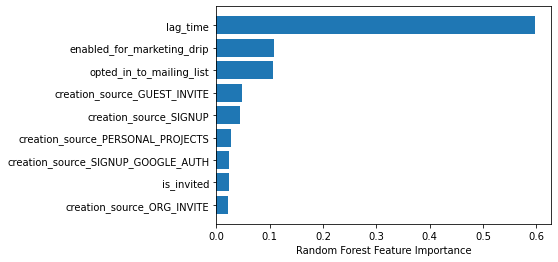

In [29]:
sorted_index = RFC.feature_importances_.argsort()
plt.barh(X.columns[sorted_index], RFC.feature_importances_[sorted_index])
plt.xlabel("Random Forest Feature Importance")
plt.show()

**Response**

I have identified the users that meet the criteria of login into product in last 7 days at least 3 times. This information is assigned as target. I have created new features:

1. lag_time: time that takes a user to login to product after creating the account. 
2. is_invited: whether a user is invited by another user or not
3. converted creation_source variable into dummy variables.

I used Random Forest Classifier as my model and it has 80.8% accuracy on the test data. I have plotted the feaure importances and here are the top 4 features for the model:
1. lag_time
2. enabled_for_marketing_drip
3. opted_in_to_mailing_list
4. creation_source_GUEST_INVITE

Based on this result the marketing team can focus on strategies to promote users to start using the app as soon as user creates an account. Marketing team can reach out to users through marketing drip campaigns and try to expand mailing lists. Also, incentives can be provided to users if they invite a new user to the app, such as referal bonus.